# A subset of high-level geospatial data science approaches*:
## Relevant core concepts and existing tools for analysis, visualization, and interpretation
*Not intended for trillions of ATL03 points

ICESat-2 hackweek  
June 18, 2019  
David Shean

## Objectives

* Review fundamental concepts that are common to most geospatial analysis (e.g. coordinate systems, geometry types)
* Learn basic data manipulation and exploration with a relatively small, clean point dataset
* Use some basic NumPy, Pandas, and Matplotlib functionality

# Introduction

## The Python data science landscape

* Jake VDP overview material
* NumPy, Pandas, Matplotlib

## The Python geospatial landscape
* geopandas, rasterio, matplotlib, GDAL, cartopy?

## Two complementary approaches for ICESat-2 data
1. Efficient, scalable processing of huge point datasets
    * numpy
    * Process your points to get the measurements you need
    * Larger than memory issues
2. Higher-level data science - *analysis, interpetation, and visualization*

## ICESat GLAS sample dataset to illustrate

## Core geospatial concepts
### Datums and projections
An essential, but often overlooked decision

#### Datum selection
* Background on ECEF, ellipsoid, and geoid heights
* Satellites use ECEF, ellipsoid is simple shape model - limited error
* Geoid models are coarse and *always* introduce error, but provide elevations 
* Sea ice, freeboard height - need to use a geoid (talk to your community on best practices)
* Careful about incorporating other datesets, geoid to ellipsoid offsets are +/-100 m
* In practice - pick one, and use it consistently for relative elevation change

#### Projection selection
* Do you need to measure distances?
* Do you need to calculate areas?  Volume change?
* In practice - community knows best practices, South Polar Stereographic (EPSG:3031), North Polar Stereographic (EPSG:3413)
* Understand the limitations - not equidistant, so velocities will contain error depending on location

## Core geospatial data operations
### Visualization: scatterplots, chloropleth maps, histograms
### Spatial selection by arbitrary polygons
### Spatial aggregation and statistics

### Saving point data
* NumPy csv output
* Geopandas/fiona - shp, geopackage, database formats, strategies

## Integrating Raster and Point data
### Loading raster DEM, basic point sampling, difference maps
### Filtering bad shots - simple cloud filter

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon

In [2]:
#Magic function to enable interactive plotting (zoom/pan) in Jupyter notebook
#If running locally, this would be `%matplotlib notebook`, but since we're using Juptyerlab, we use widget
#%matplotlib widget
%matplotlib inline

# ICESat GLAS Background
The NASA Ice Cloud and land Elevation Satellite ([ICESat](https://icesat.gsfc.nasa.gov/icesat/)) was a NASA mission carrying the Geosciences Laser Altimeter System (GLAS) instrument: a space laser, pointed down at the Earth (and unsuspecting Earthlings).  

It measured surface elevations by precisely tracking laser pulses emitted from the spacecraft at a rate of 40 Hz (a new pulse every 0.025 seconds).  These pulses traveled through the atmosphere, reflected off the surface, back up through the atmosphere, and into space, where some small fraction of that original energy was received by a large telescope on the spacecraft.  The instrument electronics precisely recorded the time when these intrepid photons left the instrument and when they returned.  The position and orientation of the spacecraft was precisely known, so the two-way traveltime (and assumptions about the speed of light and propagation through the atmosphere) allowed for precise forward determination of the spot on the Earth's surface (or cloud tops, as was often the case) where the reflection occurred.  The laser spot size varied during the mission, but was ~70 m in diameter. 

ICESat collected billions of measurements from 2003 to 2009, and was operating in a "repeat-track" mode that sacrificed spatial coverage for more observations along the same ground tracks over time.  One primary science focus involved elevation change over the Earth's ice sheets.  It allowed for early measurements of full Antarctic and Greenland ice sheet elevation change, which offered a detailed look at spatial distribution and rates of mass loss, and total ice sheet contributions to sea level rise.  

There were problems with the instrument during the mission, so it operated in short campaigns lasting only a few months to prolong the full mission lifetime.  While the primary measurements focused on the polar regions, many measurements were also collected over lower latitudes, to meet other important science objectives (e.g., estimating biomass in the Earth's forests, observing sea surface height over time). 

# Sample GLAS dataset for CONUS
A few years ago, I wanted to evaluate ICESat coverage near glaciers in the Continental United States (CONUS).  I downloaded all of the GLAS shot data, and wrote some tools to download, filter, and process the data ([https://github.com/dshean/icesat_tools](https://github.com/dshean/icesat_tools))

These scripts produced a csv file `GLAH14_tllz_conus_lulcfilt_demfilt.csv` that contains ICESat shots that passed the following filters:
* Within some buffer (~110 km) of mapped glacier polygons from the Randolph Glacier Inventory (RGI)
* Returns from exposed bare ground (31) or snow/ice (12) according to on a 30-m NLCD Land-use/Land-cover dataset
* Elevation values within some threshold (200 m, I believe) of elevations from an external reference DEM (void-filled 1/3-arcsec (30-m) SRTM-GL1), used to remove spurious points and returns from clouds.
* Various other ICESat-specific quality flags

The final file contains a very small subset (~65K) of the total shots in the original GLA14 data granules.  The remaining points should represent returns from the Earth's surface with reasonably high quality, and can be used for subsequent analysis.

In [3]:
glas_fn = 'GLAH14_tllz_conus_lulcfilt_demfilt.csv'

# NumPy

# Pandas


Trust me, you should learn how to use Pandas, regardless of your ICESat-2 application.  

A significant portion of the open source Python ecosystem is based on Pandas and/or Pandas data models.

DataSeries and DataFrame

Ever try to do a join or spatial join in GIS?  Pandas makes these very easy.

## Load the csv

Note that there are excellent readers for various file formats: https://pandas.pydata.org/pandas-docs/stable/reference/io.html

In [4]:
glas_df = pd.read_csv(glas_fn)

## Inspect the DataFrame
* full output
* head, tail
* Applying ufunc

In [5]:
glas_df.head()

,decyear,ordinal,lat,lon,glas_z,dem_z,dem_z_std,lulc
0,2003.139571,731266.943345,44.157897,-105.356562,1398.51,1400.52,0.33,31
1,2003.139571,731266.943346,44.150175,-105.358116,1387.11,1384.64,0.43,31
2,2003.139571,731266.943347,44.148632,-105.358427,1392.83,1383.49,0.28,31
3,2003.139571,731266.943347,44.147087,-105.358738,1384.24,1382.85,0.84,31
4,2003.139571,731266.943347,44.145542,-105.359048,1369.21,1380.24,1.73,31


In [6]:
glas_df.describe()

,decyear,ordinal,lat,lon,glas_z,dem_z,dem_z_std,lulc
count,65236.000000,65236.000000,65236.000000,65236.000000,65236.000000,65236.000000,65236.000000,65236.000000
mean,2005.945322,732291.890372,40.946798,-115.040612,1791.494167,1792.260964,5.504748,30.339444
std,1.729573,631.766682,3.590476,5.465065,1037.183482,1037.925371,7.518558,3.480576
min,2003.139571,731266.943345,34.999455,-124.482406,-115.550000,-114.570000,0.000000,12.000000
25%,2004.444817,731743.803182,38.101451,-119.257599,1166.970000,1168.240000,0.070000,31.000000
50%,2005.846896,732256.116938,39.884541,-115.686241,1555.730000,1556.380000,1.350000,31.000000
75%,2007.223249,732758.486046,43.453565,-109.816475,2399.355000,2400.072500,9.530000,31.000000
max,2009.775995,733691.238341,48.999727,-104.052336,4340.310000,4252.940000,49.900000,31.000000


In [7]:
glas_df.mean()

decyear        2005.945322
ordinal      732291.890372
lat              40.946798
lon            -115.040612
glas_z         1791.494167
dem_z          1792.260964
dem_z_std         5.504748
lulc             30.339444
dtype: float64

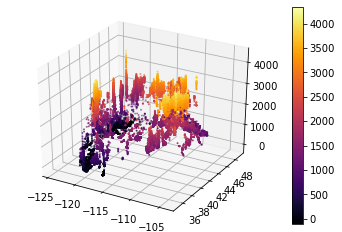

In [8]:
from mpl_toolkits.mplot3d import Axes3D
f = plt.figure()
ax3D = f.add_subplot(111, projection='3d')
sc = ax3D.scatter(glas_df['lon'], glas_df['lat'], glas_df['glas_z'], c=glas_df['glas_z'], s=1, cmap='inferno')
plt.colorbar(sc)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f64f6a0fe10>]],
      dtype=object)

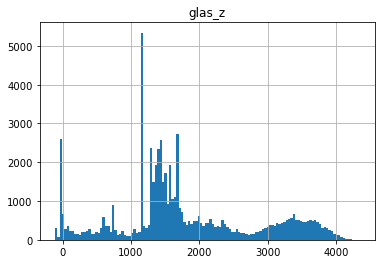

In [9]:
glas_df.hist('glas_z', bins=128)

## Compute the difference between ICESat glas_z and SRTM dem_z values
* Store as a new column in the DataFrame
* Remember the order of this calculation (if output difference values are negative, which dataset is higher?)

In [10]:
glas_df['glas_dem_diff'] = glas_df['glas_z'] - glas_df['dem_z']

## Create a scatterplot of the differences
* Use the `cmap='RdBu'` for this
* Adjust the min and max of your color ramp to be symmetrical about 0 with appropriate range to bring out detail in spatial distribution

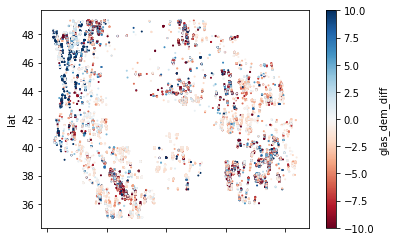

In [11]:
ax = glas_df.plot(x='lon', y='lat', kind='scatter', c='glas_dem_diff', s=1, cmap='RdBu', vmin=-10, vmax=10)

## Create a histogram of the difference values
* Limit the range to something reasonable (probably also want to increase number of bins)

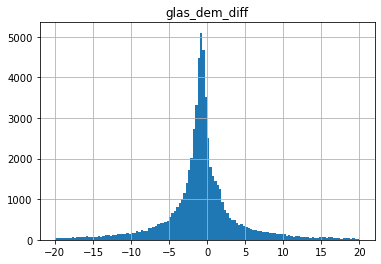

In [12]:
out = glas_df.hist('glas_dem_diff', bins=128, range=(-20,20))

# Geopandas

All the great things about Pandas, but with geo!

## Convert to a GeoDataFrame

https://geopandas.readthedocs.io/en/latest/gallery/create_geopandas_from_pandas.html

In [13]:
#Create a new geometry column containing (lon,lat) tuples for each record
glas_df['geometry'] = list(zip(glas_df['lon'], glas_df['lat']))
#Create new Point objects from the (lon,lat) tuple
glas_df['geometry'] = glas_df['geometry'].apply(Point)
#Define coordinate reference system (4326 is geographic lat/lon on WGS84 Ellispoid)
glas_gdf = gpd.GeoDataFrame(glas_df, crs={'init' :'epsg:4326'})

Run a quick `head()` to make sure everything looks good.  Note the geometry column containing Point objects.

In [14]:
glas_gdf.head()

,decyear,ordinal,lat,lon,glas_z,dem_z,dem_z_std,lulc,glas_dem_diff,geometry
0,2003.139571,731266.943345,44.157897,-105.356562,1398.51,1400.52,0.33,31,-2.01,POINT (-105.356562 44.157897)
1,2003.139571,731266.943346,44.150175,-105.358116,1387.11,1384.64,0.43,31,2.47,POINT (-105.358116 44.150175)
2,2003.139571,731266.943347,44.148632,-105.358427,1392.83,1383.49,0.28,31,9.34,POINT (-105.358427 44.148632)
3,2003.139571,731266.943347,44.147087,-105.358738,1384.24,1382.85,0.84,31,1.39,POINT (-105.358738 44.147087)
4,2003.139571,731266.943347,44.145542,-105.359048,1369.21,1380.24,1.73,31,-11.03,POINT (-105.359048 44.145542)


GeoPandas has convenience plotting function `plot()` that is built on matlplotlib

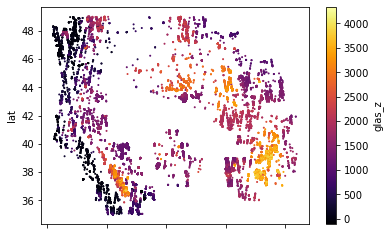

In [15]:
ax = glas_df.plot(x='lon', y='lat', kind='scatter', c='glas_z', s=1, cmap='inferno')

# Load RGI polygons

Randolph Glacier Inventory (RGI) v6.0: https://www.glims.org/RGI/

In [16]:
#Fetch the zip file (the -nc is "no-clobber", so will not overwrite existing file)
!wget -nc https://www.glims.org/RGI/rgi60_files/02_rgi60_WesternCanadaUS.zip

File ‘02_rgi60_WesternCanadaUS.zip’ already there; not retrieving.



In [17]:
#Extract to rgi subdirectory
!unzip -n -d rgi 02_rgi60_WesternCanadaUS.zip

Archive:  02_rgi60_WesternCanadaUS.zip


In [18]:
rgi_fn = 'rgi/02_rgi60_WesternCanadaUS.shp'

## Load shapefile using Geopandas

In [19]:
rgi_gdf = gpd.read_file(rgi_fn, index='RGIId')

## Inspect the GeoDataFrame
Note the geometry type is POLYGON

In [20]:
rgi_gdf.head()

,RGIId,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Area,Zmin,...,Aspect,Lmax,Status,Connect,Form,TermType,Surging,Linkages,Name,geometry
0,RGI60-02.00001,G238765E49002N,20049999,20069999,-121.235,49.0019,2,4,0.073,1938,...,345,304,0,0,0,0,0,9,None,"POLYGON ((-121.237179 49.00120000000004, -121...."
1,RGI60-02.00002,G238410E49162N,20049999,20069999,-121.590,49.1617,2,4,0.262,1726,...,6,817,0,0,0,0,0,9,None,POLYGON ((-121.5911819999999 49.15867800000007...
2,RGI60-02.00003,G238791E49163N,20049999,20069999,-121.209,49.1627,2,4,0.307,2002,...,100,478,0,0,0,0,0,9,None,"POLYGON ((-121.207506 49.16608200000007, -121...."
3,RGI60-02.00004,G238399E49166N,20049999,20069999,-121.601,49.1657,2,4,0.184,1563,...,15,376,0,0,0,0,0,9,None,POLYGON ((-121.5965409999999 49.16728500000005...
4,RGI60-02.00005,G238389E49167N,20049999,20069999,-121.611,49.1666,2,4,0.274,1668,...,50,676,0,0,0,0,0,9,None,POLYGON ((-121.6079999999999 49.16802400000006...


In [21]:
#No need for another integer index, let's just the RGI ID as our index
rgi_gdf = rgi_gdf.set_index('RGIId')

## Create a quick plot

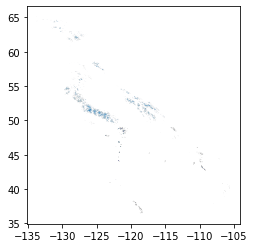

In [22]:
rgi_gdf.plot()

## Load state polygons for context

In [23]:
states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_5m.json'
#states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_500k.json'
states_gdf = gpd.read_file(states_url)

## Inspect GeoDataFrame
Note that some geometry entries are tuples of POLYGON objects - these are states with islands or rings

In [24]:
states_gdf.head()

,GEO_ID,STATE,NAME,LSAD,CENSUSAREA,geometry
0,0400000US01,01,Alabama,,50645.326,"(POLYGON ((-88.124658 30.28364, -88.0868119999..."
1,0400000US02,02,Alaska,,570640.950,"(POLYGON ((-166.10574 53.988606, -166.075283 5..."
2,0400000US04,04,Arizona,,113594.084,"POLYGON ((-112.538593 37.000674, -112.534545 3..."
3,0400000US05,05,Arkansas,,52035.477,"POLYGON ((-94.042964 33.019219, -94.043036 33...."
4,0400000US06,06,California,,155779.220,"(POLYGON ((-122.421439 37.869969, -122.421341 ..."


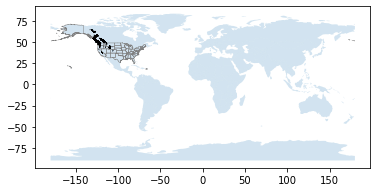

In [25]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot(alpha=0.2)
states_gdf.plot(ax=ax, facecolor='none', edgecolor='0.5', linewidth=0.5)
rgi_gdf.plot(ax=ax, edgecolor='k', linewidth=0.5)

## Clip RGI polygons to CONUS

## Note the bounds of the GLAS points
(min_x, min_y, max_x, max_y)

In [26]:
glas_gdf.total_bounds

array([-124.482406,   34.999455, -104.052336,   48.999727])

Could create a Polygon object from these coordinates as `Polygon((min_x, min_y), (min_x, max_y), (max_x, max_y), (max_x, min_y), (min_x, min_y))`

In [27]:
xmin, ymin, xmax, ymax = glas_gdf.total_bounds
rgi_gdf_conus = rgi_gdf.cx[xmin:xmax, ymin:ymax]

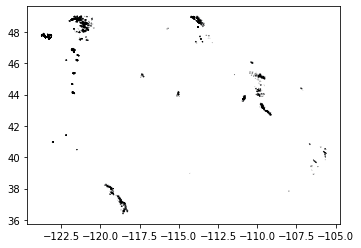

In [28]:
rgi_gdf_conus.plot(edgecolor='k')

## Let's use the convex hull polygon geometry object

To do this, we'll first take the union of our ~65K points, and then compute the convex hull

This will return a Polygon geometry object, which renders nicely in the Jupyter notebook

In [29]:
glas_gdf_chull = glas_gdf.unary_union.convex_hull

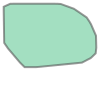

In [30]:
glas_gdf_chull

In [31]:
#Check the type
type(glas_gdf_chull)

shapely.geometry.polygon.Polygon

## Compute intersection between all RGI polygons and the convex hull
This will return a Boolean DataSeries, True if polygons intersect, False if they do not

In [32]:
rgi_gdf_idx = rgi_gdf.intersects(glas_gdf_chull)

In [33]:
rgi_gdf_idx.head()

RGIId
RGI60-02.00001    False
RGI60-02.00002    False
RGI60-02.00003    False
RGI60-02.00004    False
RGI60-02.00005    False
dtype: bool

## Extract records with True for the intersection

In [34]:
print("Number of records before:",rgi_gdf.shape[0])
rgi_gdf_conus = rgi_gdf[rgi_gdf_idx]
print("Number of records after:", rgi_gdf_conus.shape[0])

Number of records before: 18855
Number of records after: 5149


## Plot to verify
Note latitude range

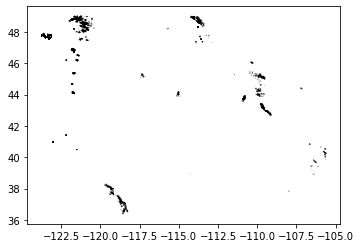

In [35]:
rgi_gdf_conus.plot(edgecolor='k')

# Projection

All of the above examples used standard geodetic lat/lon (EPSG:4326).  This is fine for global analyses, but as you already know, the width of a degree of longitude varies with latitude.

So we need to choose a map projection that is appropriate for our data.  This decision is important for visualization, but is also critical for precise analysis.  For example, if you want to compute volume change, you should use an equal-area projection.  If you want to calculate true distances between two points, you should use an equidistant projection.  

Most of you are probably used to using polar stereographic projections, likely the standard EPSG:3031 or EPSG:3413 projections for Antarctica and Greenland, respectively.  These are designed to minimize distortion near the latitude of true scale (71°S and 70°N, respectively).  This means that pixels near the pole and beyond the Antarctic coastline will have different area.  The difference isn't huge, but is nontrivial (~1-2%).  

The figures here might help illustrate: https://en.wikipedia.org/wiki/Stereographic_projection#Properties

A note on polar stereographic projections:

"The projection is defined on the entire sphere, except at one point: the projection point. Where it is defined, the mapping is smooth and bijective. It is conformal, meaning that it preserves angles at which curves meet. It is neither isometric nor area-preserving: that is, it preserves neither distances nor the areas of figures." [Wikipedia]

## Define a custom projection for CONUS

We'll use Albers Equal Area projection

In [36]:
conus_aea_proj4 = '+proj=aea +lat_1=37.31 +lat_2=46.69 +lat_0=42.00 +lon_0=-114.27 +ellps=WGS84 +units=m +no_defs'

## Reproject the GLAS points

This is simple with GeoPandas, which uses pyproj under the hood

In [37]:
glas_gdf_aea = glas_gdf.to_crs(conus_aea_proj4)

## Check the update geometry
Note the change in coordinates

In [38]:
glas_gdf_aea.head()

,decyear,ordinal,lat,lon,glas_z,dem_z,dem_z_std,lulc,glas_dem_diff,geometry
0,2003.139571,731266.943345,44.157897,-105.356562,1398.51,1400.52,0.33,31,-2.01,POINT (709799.202481625 277341.4644630185)
1,2003.139571,731266.943346,44.150175,-105.358116,1387.11,1384.64,0.43,31,2.47,POINT (709764.9868479106 276472.8763755658)
2,2003.139571,731266.943347,44.148632,-105.358427,1392.83,1383.49,0.28,31,9.34,POINT (709758.1079927931 276299.311774242)
3,2003.139571,731266.943347,44.147087,-105.358738,1384.24,1382.85,0.84,31,1.39,POINT (709751.2509753814 276125.5253733542)
4,2003.139571,731266.943347,44.145542,-105.359048,1369.21,1380.24,1.73,31,-11.03,POINT (709744.4720842609 275951.747074242)


## Plot the projected points

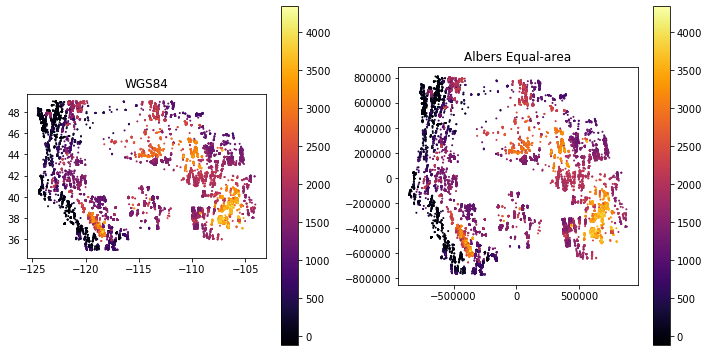

In [39]:
f, axa = plt.subplots(1,2, figsize=(10,5))
glas_gdf.plot(ax=axa[0], column='glas_z', cmap='inferno', markersize=1, legend=True)
axa[0].set_title('WGS84')
glas_gdf_aea.plot(ax=axa[1], column='glas_z', cmap='inferno', markersize=1, legend=True)
axa[1].set_title('Albers Equal-area')
plt.tight_layout()

## OK, great, but what did we just do?

Under the hood, GeoPandas used fiona and the proj library to transform each point from one coordinate system to another coordinate system.  

You've all done this kind of thing before: https://en.wikipedia.org/wiki/List_of_common_coordinate_transformations

In 2D, transforming (x,y) coordinates between different projections (e.g., WGS84 vs. Albers Equal Area) on the same reference ellipsoid is pretty straightforward.  Things start to get more complicated when you include different ellipsoid models, horizontal/vertical datums, etc.  Oh, also the Earth's surface is not static - plate tectonics make everything more complicated, as time becomes important, and transformations must include a "kinematic" component.  

Fortunately, the PROJ library (https://proj4.org/about.html) has generalized much of the complicated math for geodetic coordinate transformations.  It's been under development since the 1980s, and our understanding of the Earth's shape and plate motions has changed dramatically in that time period.  So, still pretty complicated, and there are different levels of support/sophistication in the tools/libraries that use PROJ (like fiona or GeoPandas).

We aren't going to get into the details here, but quickly take a look at the Transformations section here to get a sense of how this is actually accomplished: https://proj4.org/operations/index.html

# Combined plot

In [40]:
# Let's reproject the state and RGI polygons
states_gdf_aea = states_gdf.to_crs(conus_aea_proj4)
rgi_gdf_conus_aea = rgi_gdf_conus.to_crs(conus_aea_proj4)

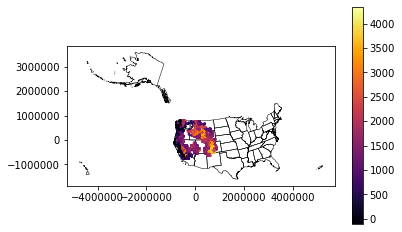

In [41]:
ax = states_gdf_aea.plot(edgecolor='k', facecolor='none', lw=0.5)
rgi_gdf_conus_aea.plot(ax=ax, edgecolor='k', lw=0.5, alpha=0.5)
glas_gdf_aea.plot(ax=ax, column='glas_z', cmap='inferno', markersize=1, legend=True)
#glas_gdf_aea.plot(ax=ax, column='decyear', cmap='inferno', markersize=1, legend=True)

# Isolate Washington state

In [42]:
states_gdf_aea.tail()

,GEO_ID,STATE,NAME,LSAD,CENSUSAREA,geometry
47,0400000US53,53,Washington,,66455.521,(POLYGON ((-613063.6560906336 729252.630207761...
48,0400000US54,54,West Virginia,,24038.210,"POLYGON ((2847979.733600043 320554.9281195875,..."
49,0400000US55,55,Wisconsin,,54157.805,(POLYGON ((1792023.037389984 810291.3473061091...
50,0400000US56,56,Wyoming,,97093.141,POLYGON ((353937.4584018005 -103001.1499615973...
51,0400000US72,72,Puerto Rico,,3423.775,(POLYGON ((5215855.649893587 -1049042.95237122...


In [43]:
wa_state = states_gdf_aea.loc[states_gdf_aea['NAME'] == 'Washington']
wa_geom = wa_state.iloc[0].geometry

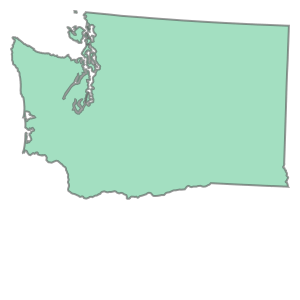

In [44]:
wa_geom

In [45]:
bbox = wa_state.total_bounds
ax.set_xlim(bbox[0], bbox[2])
ax.set_ylim(bbox[1], bbox[3])

(423330.5507755639, 812113.0154087446)

# Part 2: Analysis
Let's see if glacier elevation changed from SRTM to GLAS

## Merge GLAS points with RGI polygons

In [46]:
rgi_gdf_conus_aea.columns

Index(['GLIMSId', 'BgnDate', 'EndDate', 'CenLon', 'CenLat', 'O1Region',
       'O2Region', 'Area', 'Zmin', 'Zmax', 'Zmed', 'Slope', 'Aspect', 'Lmax',
       'Status', 'Connect', 'Form', 'TermType', 'Surging', 'Linkages', 'Name',
       'geometry'],
      dtype='object')

In [47]:
glas_gdf_aea.columns

Index(['decyear', 'ordinal', 'lat', 'lon', 'glas_z', 'dem_z', 'dem_z_std',
       'lulc', 'glas_dem_diff', 'geometry'],
      dtype='object')

## Perform a spatial join
http://geopandas.org/reference/geopandas.sjoin.html#geopandas.sjoin
Preserve all fields in GLAS GeoDataFrame  
Isolate RGIId, glacier name (if availabile) from RGI

In [48]:
glas_gdf_aea_rgi = gpd.sjoin(glas_gdf_aea, rgi_gdf_conus_aea[['Area','Name','geometry']], op='intersects', how='inner')

In [49]:
glas_gdf_aea_rgi.columns

Index(['decyear', 'ordinal', 'lat', 'lon', 'glas_z', 'dem_z', 'dem_z_std',
       'lulc', 'glas_dem_diff', 'geometry', 'index_right', 'Area', 'Name'],
      dtype='object')

In [50]:
glas_gdf_aea_rgi.head()

,decyear,ordinal,lat,lon,glas_z,dem_z,dem_z_std,lulc,glas_dem_diff,geometry,index_right,Area,Name
1032,2003.162887,731275.453606,48.672276,-121.532290,1798.45,1791.25,5.63,12,7.20,POINT (-536290.6968751887 765027.7300854146),RGI60-02.17369,2.819,Noisy Creek Glacier
5393,2003.753883,731491.167315,48.669686,-121.525707,1826.79,1832.08,8.82,12,-5.29,POINT (-535829.9284047344 764700.7641614984),RGI60-02.17369,2.819,Noisy Creek Glacier
5394,2003.753883,731491.167315,48.671225,-121.526056,1795.05,1795.39,3.60,12,-0.34,POINT (-535841.2584876922 764872.8200801831),RGI60-02.17369,2.819,Noisy Creek Glacier
5395,2003.753883,731491.167315,48.672763,-121.526408,1768.91,1768.20,3.47,12,0.71,POINT (-535852.8175845263 765044.7837475365),RGI60-02.17369,2.819,Noisy Creek Glacier
5396,2003.753883,731491.167316,48.674303,-121.526762,1745.11,1745.54,3.98,12,-0.43,POINT (-535864.5039730374 765216.9800739347),RGI60-02.17369,2.819,Noisy Creek Glacier


In [51]:
glas_gdf_aea_rgi = glas_gdf_aea_rgi.rename(columns={"index_right": "RGIId"})

In [52]:
rgi_gdf_conus_aea.shape

(5149, 22)

In [53]:
glas_gdf_aea_rgi.shape

(822, 13)

In [54]:
glas_gdf_aea_rgi['RGIId'].value_counts()

RGI60-02.14588    49
RGI60-02.13805    45
RGI60-02.17727    43
RGI60-02.14005    33
RGI60-02.14103    30
RGI60-02.17726    29
RGI60-02.14586    21
RGI60-02.17725    21
RGI60-02.14041    21
RGI60-02.14277    20
RGI60-02.17729    17
RGI60-02.18821    16
RGI60-02.14335    16
RGI60-02.18776    14
RGI60-02.14297    14
RGI60-02.18763    14
RGI60-02.18764    13
RGI60-02.14315    13
RGI60-02.13741    12
RGI60-02.14101    11
RGI60-02.14293    11
RGI60-02.13806    10
RGI60-02.18068     9
RGI60-02.14016     9
RGI60-02.18817     8
RGI60-02.13785     8
RGI60-02.17369     7
RGI60-02.18523     7
RGI60-02.14323     7
RGI60-02.18084     7
                  ..
RGI60-02.15491     1
RGI60-02.13780     1
RGI60-02.15471     1
RGI60-02.14266     1
RGI60-02.15388     1
RGI60-02.15676     1
RGI60-02.17543     1
RGI60-02.17135     1
RGI60-02.15478     1
RGI60-02.18189     1
RGI60-02.15177     1
RGI60-02.13776     1
RGI60-02.14610     1
RGI60-02.18611     1
RGI60-02.14050     1
RGI60-02.16467     1
RGI60-02.1862

In [55]:
glas_gdf_aea_rgi.describe()

,decyear,ordinal,lat,lon,glas_z,dem_z,dem_z_std,lulc,glas_dem_diff,Area
count,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000
mean,2005.981947,732305.275639,46.297184,-120.904121,2272.290474,2279.316387,10.598905,17.986618,-7.025912,1.443953
std,1.507469,550.619548,2.949723,3.397248,610.104420,604.366088,6.040922,8.831820,20.421389,1.942288
min,2003.162887,731275.453606,36.693917,-123.667993,789.050000,824.050000,0.560000,12.000000,-106.030000,0.011000
25%,2004.766882,731861.678761,44.198088,-122.184204,1814.795000,1828.645000,6.140000,12.000000,-16.665000,0.174000
50%,2005.894938,732273.652372,46.889112,-121.697205,2209.875000,2214.450000,9.645000,12.000000,-3.315000,0.660000
75%,2007.201366,732750.498753,48.665049,-121.561070,2517.662500,2505.077500,13.555000,31.000000,3.735000,2.213000
max,2009.771998,733689.779276,48.998648,-105.952878,3913.040000,3921.140000,45.040000,31.000000,199.350000,10.594000


## Groupby and Aggregate

https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html

In [56]:
glas_gdf_aea_rgi.groupby('RGIId')

In [57]:
glas_gdf_aea_rgi.groupby('RGIId').median().head()

,decyear,ordinal,lat,lon,glas_z,dem_z,dem_z_std,lulc,glas_dem_diff,Area
RGIId,,,,,,,,,,
RGI60-02.13741,2007.012575,732681.589973,44.151638,-121.766431,2351.530,2348.52,6.390,12.0,3.680,0.808
RGI60-02.13756,2007.762265,732955.226787,44.154439,-121.766029,2309.530,2309.58,9.650,31.0,3.740,0.074
RGI60-02.13761,2007.762265,732955.226789,44.163874,-121.767570,2577.600,2566.26,25.190,31.0,11.340,0.104
RGI60-02.13769,2007.762265,732955.226790,44.170061,-121.769645,2689.840,2694.60,21.400,31.0,-4.760,0.051
RGI60-02.13770,2004.766882,731861.678773,44.175885,-121.774319,2394.325,2391.60,10.715,31.0,2.725,0.144


In [58]:
glas_gdf_aea_rgi.groupby('RGIId').count().head()

,decyear,ordinal,lat,lon,glas_z,dem_z,dem_z_std,lulc,glas_dem_diff,geometry,Area,Name
RGIId,,,,,,,,,,,,
RGI60-02.13741,12,12,12,12,12,12,12,12,12,12,12,12
RGI60-02.13756,7,7,7,7,7,7,7,7,7,7,7,7
RGI60-02.13761,1,1,1,1,1,1,1,1,1,1,1,1
RGI60-02.13769,3,3,3,3,3,3,3,3,3,3,3,3
RGI60-02.13770,4,4,4,4,4,4,4,4,4,4,4,4


In [116]:
agg_func = {'Name':'first',
            'Area':'first', 
            'glas_z':['mean', 'median', 'std'],
            'glas_dem_diff':['count','mean', 'median', 'std']}
glas_gdf_aea_rgi_agg = glas_gdf_aea_rgi.groupby('RGIId').agg(agg_func)

In [117]:
glas_gdf_aea_rgi_agg.head()

Name   Area       glas_z                        \
                             first  first         mean    median         std   
RGIId                                                                          
RGI60-02.13741   Hayden Glacier OR  0.808  2367.762500  2351.530   44.709595   
RGI60-02.13756                  OR  0.074  2334.240000  2309.530   40.594923   
RGI60-02.13761   Thayer Glacier OR  0.104  2577.600000  2577.600         NaN   
RGI60-02.13769  Villard Glacier OR  0.051  2710.566667  2689.840   54.160927   
RGI60-02.13770     Linn Glacier OR  0.144  2453.932500  2394.325  172.569776   

               glas_dem_diff                                
                       count       mean  median        std  
RGIId                                                       
RGI60-02.13741            12   2.049167   3.680   4.940891  
RGI60-02.13756             7   6.715714   3.740  10.503861  
RGI60-02.13761             1  11.340000  11.340        NaN  
RGI60-02.13769             3  -3.870000  -4.760   2.148046  
RGI60-02.13770             4   1.315000   2.725   3.755640

In [118]:
# We don't need the multi-index here
#glas_gdf_aea_rgi_agg.columns = list(map('_'.join, glas_gdf_aea_rgi_agg.columns.values))
#glas_gdf_aea_rgi_agg.columns = glas_gdf_aea_rgi_agg.columns.get_level_values(0)
glas_gdf_aea_rgi_agg.columns = ['_'.join(col).rstrip('_') for col in glas_gdf_aea_rgi_agg.columns.values]

In [119]:
glas_gdf_aea_rgi_agg.head()

,Name_first,Area_first,glas_z_mean,glas_z_median,glas_z_std,glas_dem_diff_count,glas_dem_diff_mean,glas_dem_diff_median,glas_dem_diff_std
RGIId,,,,,,,,,
RGI60-02.13741,Hayden Glacier OR,0.808,2367.762500,2351.530,44.709595,12,2.049167,3.680,4.940891
RGI60-02.13756,OR,0.074,2334.240000,2309.530,40.594923,7,6.715714,3.740,10.503861
RGI60-02.13761,Thayer Glacier OR,0.104,2577.600000,2577.600,NaN,1,11.340000,11.340,NaN
RGI60-02.13769,Villard Glacier OR,0.051,2710.566667,2689.840,54.160927,3,-3.870000,-4.760,2.148046
RGI60-02.13770,Linn Glacier OR,0.144,2453.932500,2394.325,172.569776,4,1.315000,2.725,3.755640


In [120]:
rgi_gdf_conus_aea['geometry'].head()

RGIId
RGI60-02.13700    POLYGON ((733183.8562791409 -182439.9539486785...
RGI60-02.13701    POLYGON ((733108.950973706 -183368.1988575285,...
RGI60-02.13702    POLYGON ((733034.5516035394 -180342.9573478426...
RGI60-02.13703    POLYGON ((731622.1793600245 -179141.0037190297...
RGI60-02.13704    POLYGON ((730885.0062104709 -178746.0156964659...
Name: geometry, dtype: object

In [121]:
glas_gdf_aea_rgi_agg_gdf = gpd.GeoDataFrame(glas_gdf_aea_rgi_agg, geometry=rgi_gdf_conus_aea['geometry'])

In [123]:
glas_gdf_aea_rgi_agg_gdf.head()

,Name_first,Area_first,glas_z_mean,glas_z_median,glas_z_std,glas_dem_diff_count,glas_dem_diff_mean,glas_dem_diff_median,glas_dem_diff_std,geometry
RGIId,,,,,,,,,,
RGI60-02.13741,Hayden Glacier OR,0.808,2367.762500,2351.530,44.709595,12,2.049167,3.680,4.940891,POLYGON ((-598133.6174021332 265564.6568703279...
RGI60-02.13756,OR,0.074,2334.240000,2309.530,40.594923,7,6.715714,3.740,10.503861,POLYGON ((-597218.1615705864 266082.6795769816...
RGI60-02.13761,Thayer Glacier OR,0.104,2577.600000,2577.600,NaN,1,11.340000,11.340,NaN,POLYGON ((-596960.0799126084 266987.2218985451...
RGI60-02.13769,Villard Glacier OR,0.051,2710.566667,2689.840,54.160927,3,-3.870000,-4.760,2.148046,"POLYGON ((-597525.68864642 267742.8300522462, ..."
RGI60-02.13770,Linn Glacier OR,0.144,2453.932500,2394.325,172.569776,4,1.315000,2.725,3.755640,POLYGON ((-597605.7763857148 268593.7655254385...


In [124]:
glas_gdf_aea_rgi_agg_gdf.geometry

RGIId
RGI60-02.13741    POLYGON ((-598133.6174021332 265564.6568703279...
RGI60-02.13756    POLYGON ((-597218.1615705864 266082.6795769816...
RGI60-02.13761    POLYGON ((-596960.0799126084 266987.2218985451...
RGI60-02.13769    POLYGON ((-597525.68864642 267742.8300522462, ...
RGI60-02.13770    POLYGON ((-597605.7763857148 268593.7655254385...
RGI60-02.13771    POLYGON ((-596561.5810528718 268143.1577314306...
RGI60-02.13772    POLYGON ((-596748.3097899234 267914.5873186314...
RGI60-02.13776    POLYGON ((-597675.570369039 269310.6839748939,...
RGI60-02.13777    POLYGON ((-597458.5092044317 268461.8332309689...
RGI60-02.13780    POLYGON ((-597288.1410328485 270171.8698224709...
RGI60-02.13781    POLYGON ((-596841.5040343407 264084.9940172167...
RGI60-02.13782    POLYGON ((-597410.8646982416 269795.2166673868...
RGI60-02.13784    POLYGON ((-596515.8815787395 269505.2882300653...
RGI60-02.13785    POLYGON ((-597478.7490534931 270826.830655888,...
RGI60-02.13789    POLYGON ((-597487.420950

In [63]:
glas_gdf_aea_rgi_agg_gdf.head()

,Name_first,Area_first,glas_z_mean,glas_z_median,glas_z_std,glas_dem_diff_count,glas_dem_diff_mean,glas_dem_diff_median,glas_dem_diff_std,geometry
RGIId,,,,,,,,,,
RGI60-02.13741,Hayden Glacier OR,0.808,2367.762500,2351.530,44.709595,12,2.049167,3.680,4.940891,POLYGON ((-598133.6174021332 265564.6568703279...
RGI60-02.13756,OR,0.074,2334.240000,2309.530,40.594923,7,6.715714,3.740,10.503861,POLYGON ((-597218.1615705864 266082.6795769816...
RGI60-02.13761,Thayer Glacier OR,0.104,2577.600000,2577.600,NaN,1,11.340000,11.340,NaN,POLYGON ((-596960.0799126084 266987.2218985451...
RGI60-02.13769,Villard Glacier OR,0.051,2710.566667,2689.840,54.160927,3,-3.870000,-4.760,2.148046,"POLYGON ((-597525.68864642 267742.8300522462, ..."
RGI60-02.13770,Linn Glacier OR,0.144,2453.932500,2394.325,172.569776,4,1.315000,2.725,3.755640,POLYGON ((-597605.7763857148 268593.7655254385...


In [64]:
#!pip install matplotlib-scalebar

In [65]:
#!conda install -c conda-forge -y contextily

In [66]:
from matplotlib_scalebar.scalebar import ScaleBar
import contextily as ctx

In [67]:
def add_basemap(ax, zoom, url='http://tile.stamen.com/terrain/tileZ/tileX/tileY.png'):
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    # restore original x/y limits
    ax.axis((xmin, xmax, ymin, ymax))
    scalebar = ScaleBar(1.0)
    ax.add_artist(scalebar)

In [68]:
#Convert to web mercator (EPSG:3857) to match format of tiled basemap
glas_gdf_aea_rgi_agg_gdf_wm = glas_gdf_aea_rgi_agg_gdf.to_crs(epsg=3857)
glas_gdf_aea_rgi_wm = glas_gdf_aea_rgi.to_crs(epsg=3857)

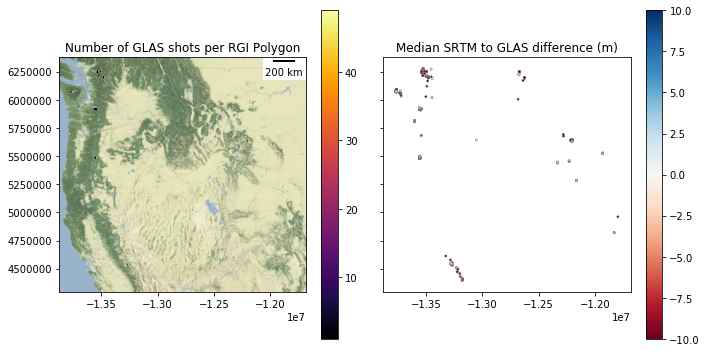

In [69]:
f, axa = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)
#glas_gdf_aea_rgi_agg_gdf.plot(column=('glas_dem_diff', 'count'))
glas_gdf_aea_rgi_agg_gdf_wm.plot(ax=axa[0],column='glas_dem_diff_count', cmap='inferno', edgecolor='k', lw=0.5, legend=True)
axa[0].set_title('Number of GLAS shots per RGI Polygon')
glas_gdf_aea_rgi_agg_gdf_wm.plot(ax=axa[1],column='glas_dem_diff_median', cmap='RdBu', edgecolor='k', lw=0.5, vmin=-10, vmax=10, legend=True)
axa[1].set_title('Median SRTM to GLAS difference (m)')
glas_gdf_aea_rgi_wm.plot(ax=axa[1],column='glas_dem_diff', cmap='RdBu', markersize=5, edgecolor='0.5', lw=0.5, vmin=-10, vmax=10)
add_basemap(axa[0], zoom=8)
plt.tight_layout()

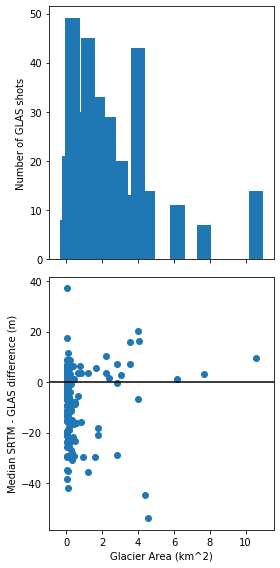

In [71]:
f, axa = plt.subplots(2, sharex=True, figsize=(4, 8))
axa[0].bar(glas_gdf_aea_rgi_agg_gdf['Area_first'], glas_gdf_aea_rgi_agg_gdf['glas_dem_diff_count'])
#axa[0].set_xlabel('Glacier Area (km^2)')
axa[0].set_ylabel('Number of GLAS shots')
axa[1].scatter(glas_gdf_aea_rgi_agg_gdf['Area_first'], glas_gdf_aea_rgi_agg_gdf['glas_dem_diff_median'])
axa[1].set_xlabel('Glacier Area (km^2)')
axa[1].set_ylabel('Median SRTM - GLAS difference (m)')
axa[1].axhline(0, color='k')
plt.tight_layout()

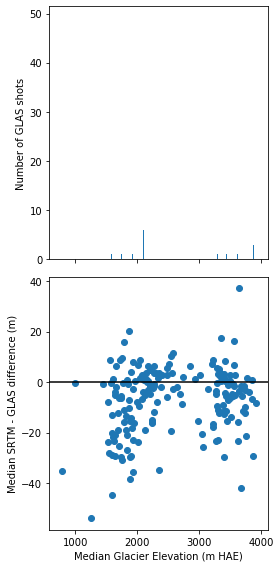

In [73]:
f, axa = plt.subplots(2, sharex=True, figsize=(4, 8))
axa[0].bar(glas_gdf_aea_rgi_agg_gdf['glas_z_median'], glas_gdf_aea_rgi_agg_gdf['glas_dem_diff_count'])
#axa[0].set_xlabel('Glacier Area (km^2)')
axa[0].set_ylabel('Number of GLAS shots')
axa[1].scatter(glas_gdf_aea_rgi_agg_gdf['glas_z_median'], glas_gdf_aea_rgi_agg_gdf['glas_dem_diff_median'])
axa[1].set_xlabel('Median Glacier Elevation (m HAE)')
axa[1].set_ylabel('Median SRTM - GLAS difference (m)')
axa[1].axhline(0, color='k')
plt.tight_layout()

(423330.5507755639, 812113.0154087446)

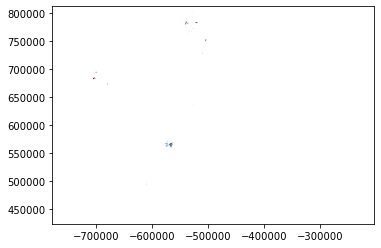

In [74]:
ax = glas_gdf_aea_rgi_agg_gdf.plot(column='glas_dem_diff_median', cmap='RdBu', vmin=-10, vmax=10)
ax.set_xlim(bbox[0], bbox[2])
ax.set_ylim(bbox[1], bbox[3])

In [100]:
gname = 'Emmons Glacier WA'

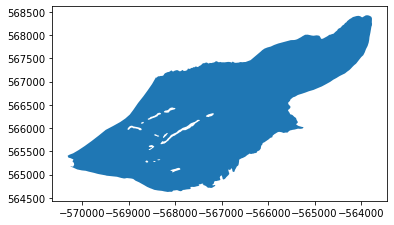

In [102]:
glas_gdf_aea_rgi_agg_gdf[glas_gdf_aea_rgi_agg_gdf['Name_first'] == gname].plot()

In [97]:
glas_gdf_aea_rgi_agg_gdf[glas_gdf_aea_rgi_agg_gdf.apply(lambda row: row.astype(str).str.contains(gname).any(), axis=1)]

,Name_first,Area_first,glas_z_mean,glas_z_median,glas_z_std,glas_dem_diff_count,glas_dem_diff_mean,glas_dem_diff_median,glas_dem_diff_std,geometry
RGIId,,,,,,,,,,
RGI60-02.14297,Emmons Glacier WA,10.594,1748.737143,1761.815,49.889179,14,11.447857,9.515,7.517299,"POLYGON ((-564219.2227481529 567281.052260328,..."


## Save output as GIS-ready file

The workflows we're developing with Jupyter Notebooks are intended to be all-inclusive and reproducible - they start by reading raw data and end with final results.

But sometimes you want to write out geospatial data for analysis in a GUI-based GIS (QGIS, ArcMap) to share with colleagues

## How to choose a format?
Under the hood, geopandas uses the `fiona` package for reading/writing vector data

`fiona.supported_drivers`

```
{'ARCGEN': 'r',
 'AeronavFAA': 'r',
 'BNA': 'raw',
 'CSV': 'raw',
 'DGN': 'raw',
 'DXF': 'raw',
 'ESRI Shapefile': 'raw',
 'GML': 'raw',
 'GPKG': 'rw',
 'GPSTrackMaker': 'raw',
 'GPX': 'raw',
 'GeoJSON': 'rw',
 'Idrisi': 'r',
 'MapInfo File': 'raw',
 'OpenFileGDB': 'r',
 'PCIDSK': 'r',
 'S57': 'r',
 'SEGY': 'r',
 'SUA': 'r'}
 ```

* You've all used shapefiles in the past.  Please stop.  This is a legacy format, though it is still widely used.
* http://switchfromshapefile.org/
* Better options these days are Geopackage (GPKG) when spatial index is required, and GeoJSON for most cases - both should be supported by any respectable GIS
* Let's use geopackage for this exercise
* Now that you've made an informed decision, pick a filename and use the Geopandas `to_file()` method
    * Make sure you properly specify filename with extension and the `driver` option
    * Note: Writing out may take a minute, and may produce an intermediate '.gpkg-journal' file

In [112]:
glas_gdf_aea_rgi_agg_gdf.shape

(185, 10)

In [126]:
out_fn='./conus_glas_gdf_aea_rgi_agg.gpkg'
glas_gdf_aea_rgi_agg_gdf.to_file(out_fn, driver='GPKG')
#out_fn='./conus_glas_gdf_aea_rgi_agg.geojson'
#glas_gdf_aea_rgi_agg_gdf.to_file(out_fn, driver='GeoJSON')

## :tada:

You can now directly load this gpkg file in any GIS, without defining a coordinate system or dealing with your original csv.  

Try it! Right-click on file in the file browser (left side of the JupyterLab interface) -> Download.  Then open in QGIS on your local machine.

You can also load this file directly into geopandas in the future using the `read_file()` method, without having to do any of the processing above.

# Hexbin plots
* Hopefully the above got you thinking about projections again.  An equal-area projection is a good idea for a hexbin plot, so use your AEA points here.
* Hexbin plots are great for visualizing spatial distribution of point density
* Here are some resources:
    * https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hexbin.html
    * http://darribas.org/gds15/content/labs/lab_09.html
* Create a hexbin that shows the number of points in each cell
    * Play around with the `gridsize` option (or specify the dimensions of your bins) appropriately
    * Use the `mincnt` option to avoid plotting cells with 0 count
    * Overlay the state polygons to help visualize
    * Tweak your xlim and ylim to the GLAS point bounds
    * Can use linear color ramp with vmin and vmax options, or try a 'log' color ramp, since we have a broad range of counts
* Create a second hexbin plot that shows the median elevation in each bin
    * See documentation for the `C` and `reduce_C_function` options

In [ ]:
nbins = 40
nbins_m = 27000
bbox = glas_gdf_aea.total_bounds
nbins_x = int(np.ceil(np.abs(bbox[2] - bbox[0])/nbins_m))
nbins_y = int(np.ceil(np.abs(bbox[3] - bbox[1])/nbins_m))
print(nbins_x, nbins_y)
nbins = nbins_x

In [ ]:
bbox

In [ ]:
f,ax = plt.subplots(figsize=(8,8))
hb=ax.hexbin(glas_gdf_aea.geometry.x, glas_gdf_aea.geometry.y, gridsize=nbins, cmap='inferno', bins='log', alpha=0.6, mincnt=1)
plt.colorbar(hb, label='Point density')
#hb = ax.hexbin(glas_gdf_aea.geometry.x, glas_gdf_aea.geometry.y, C=glas_gdf_aea['glas_z'], reduce_C_function=np.median, gridsize=nbins, cmap='inferno', alpha=0.6)#, vmin=0, vmax=100)
#plt.colorbar(hb, ax=ax, label='Bin median elevation')
states_gdf_aea.plot(ax=ax, facecolor='none', edgecolor='black')
ax.set_xlim(bbox[[0,2]])
ax.set_ylim(bbox[[1,3]])